In [93]:
%run ../initEnviroment.py
from plot_data import PlotActivity
from scipy.stats import norm, kurtosis
import os
from scipy.signal import butter, lfilter, freqz
from scipy import signal

# Data Preprocessing

## Plot activity

In [10]:
plot = PlotActivity(4,"acc") #experiment 1

<Figure size 1152x864 with 0 Axes>

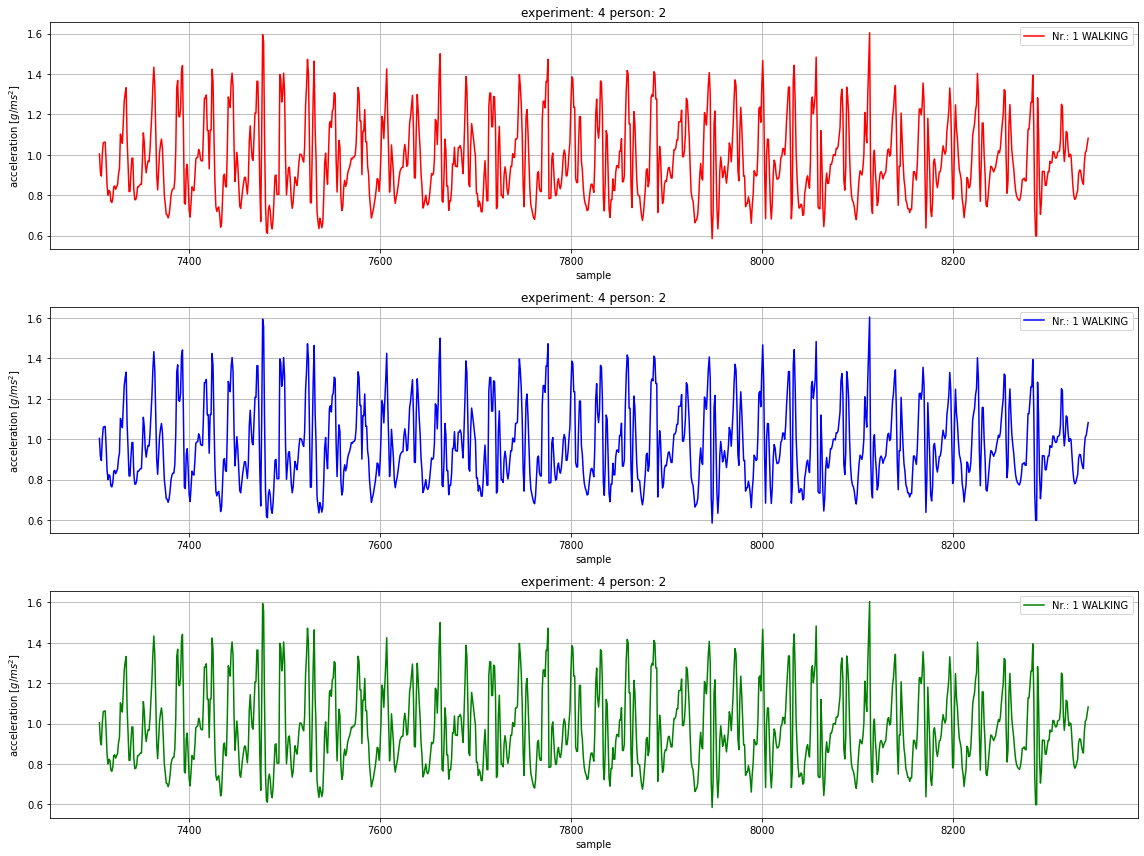

<Figure size 1152x864 with 0 Axes>

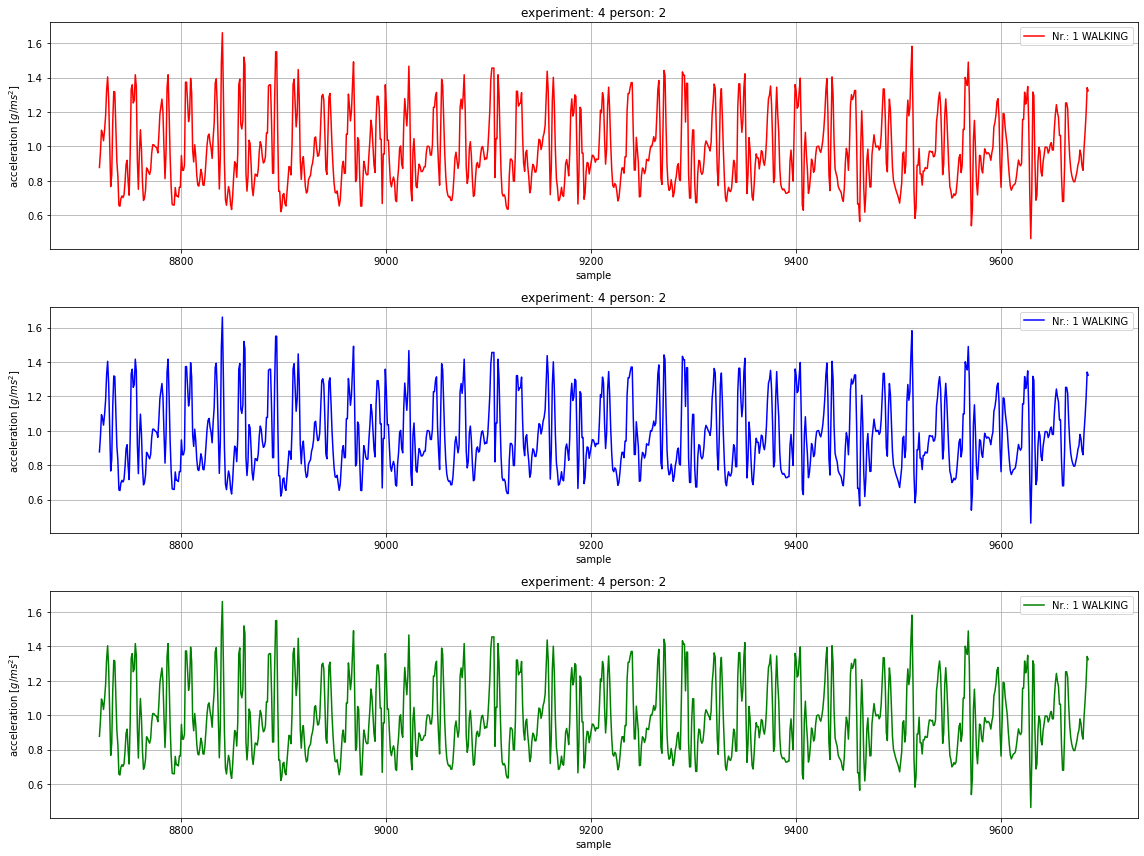

In [11]:
plot.plot_activity(1) #activity 1

## Read all data

To get an appropriate DataFrame, we need to use the `labels.txt`. In this file there are informations about the experiment, person activity and the start and end informations.

|experiment|person|activity|start|end|
|----------|------|--------|-----|---|
|Id of the experiment|Id of the person|Id of the activity|activity start|activity end|


There are 61 raw data files. In these files there are 6 signals. 3 singnals for the accelerometer (x,y,z). And 3 for the gyroscope (x,y,z).
The sample rate of the measurements is 50Hz. This means there is a data point in each 0.02 seconds. 

As before mentioned there are 61 files, but it would be better to work only with one dataframe. To do so, we can merge all of them, and than we will have a huge dataframe with all measurements.
With a mapping function it is possible to extend the data with the corresponding labels from the labels.txt.

In [2]:
labels = pd.read_csv('../data/RawData/labels.txt', sep=" ", header=None)
labels.columns = ['experiment','person','activity','start','end']

In [3]:
def read_data():
    """Read all data to a dataframe"""
    
    list_df = [] #a list to collect the dataframes
    
    for i in range(1,62):
        
        if i < 10:
            i = '0' + str(i)
        else:
            i = str(i)
            
        for j in os.listdir('../data/RawData/'):
   
            if "acc_exp" + i in j:
                acc_path = "../data/RawData/" + j
                
            elif "gyro_exp" + i in j:
                gyro_path = "../data/RawData/" + j
                    
        acc_df = pd.read_csv(acc_path, sep = " ", names=['acc_x','acc_y','acc_z'])
        gyro_df = pd.read_csv(gyro_path, sep = " ", names=['gyro_x','gyro_y','gyro_z'])
        
        exp_df = pd.concat([acc_df,gyro_df],1)
        exp_df["experiment"] = int(i) #keep track of the experiment
        
        list_df.append(exp_df)
    
    df = pd.concat(list_df)
        
    return df

In [4]:
df = read_data()

### Add labels

In [5]:
def add_activity_label(df):
    """Add activity labels form the labels dataframe"""
    
    df = df.reset_index()
    df = df.rename(columns={"index": "id"})

    df["activity"] = 0

    for index,row in labels.iterrows():

        df["activity"] = np.where((df.experiment == row["experiment"]) \
                                    & ((df.id >= row["start"]) & (df.id < row["end"])),
                                    row["activity"], df["activity"])
        
    return df

In [14]:
labeled_df = add_activity_label(df)

### Drop not activities

In [8]:
labeled_df = drop_unlabeled(labeled_df)

## Frequency filter 

The measurements are continous measurements. This means, there are some part of the measurements where there is no useful data (*not labeld*). We can easily drop them.

In order to analyse only the usful part of the sensors, we need to use frequency filters. The human activities are in the low frequency range. For example the wolking is in the range of 1-3Hz [1].

The low pass filter are the appropriate tool for only use valuable range.

[1] https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3231187/

In [15]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

###  Test the filter

In [49]:
test_sig = labeled_df[(labeled_df["experiment"] == 1)]["acc_x"]

Text(0, 0.5, 'amplitude')

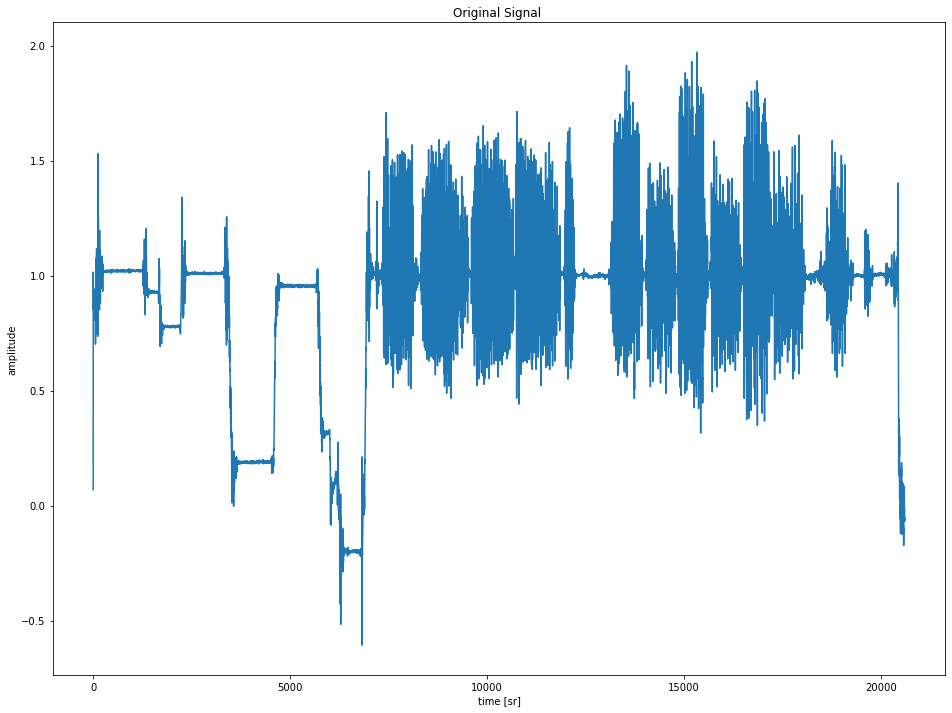

In [50]:
plt.plot(test_sig)

plt.title("Original Signal ")
plt.xlabel("time [sr]")
plt.ylabel("amplitude")

In [55]:
y_f = butter_lowpass_filter(test_sig.to_numpy(),1,50,order=2)

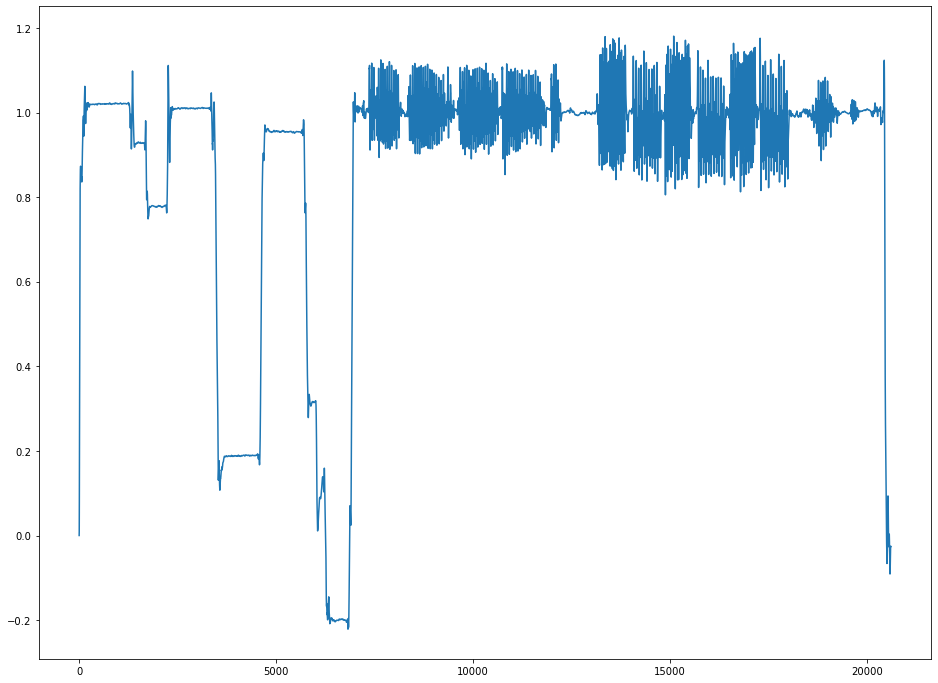

In [56]:
plt.plot(y_f)

Filter all of the the measurements.

In [57]:
def filter_acc(df, cutoff=10, fs=50, order=2):
    
    signals = ["acc_x","acc_y","acc_z"]
    
    new_df = pd.DataFrame(columns=signals)
    
    for experiment in df.experiment.unique():
    
        experiment_df = df[df.experiment == experiment]
        
        list_signals = []
        
        for j in signals:
            
            filtered_signal = butter_lowpass_filter(experiment_df[j], cutoff=cutoff, fs=fs, order=order)
            
            list_signals.append(filtered_signal)
        
        new_df = pd.concat([new_df, pd.DataFrame(np.array(list_signals).T,columns=signals)])
        
    return new_df


def filter_gyro(df, cutoff=10, fs=50, order=2):
    
    signals = ["gyro_x","gyro_y","gyro_z"]
    
    new_df = pd.DataFrame(columns=signals)
    
    for experiment in df.experiment.unique():
    
        experiment_df = df[df.experiment == experiment]
        
        list_signals = []
        
        for j in signals:
            
            filtered_signal = butter_lowpass_filter(experiment_df[j], cutoff=cutoff, fs=fs, order=order)
            
            list_signals.append(filtered_signal)
        
        new_df = pd.concat([new_df, pd.DataFrame(np.array(list_signals).T,columns=signals)])
        
    return new_df

In [41]:
filtered_df_acc = filter_acc(labeled_df,cutoff = 12)
filtered_df_gyro = filter_gyro(labeled_df,cutoff= 2)

Create the dataframe with the filtered signals

In [58]:
labeled_df = pd.concat([labeled_df.drop(["acc_x","acc_y","acc_z","gyro_x","gyro_y","gyro_z"],axis=1),
                       filtered_df_acc.reset_index(drop=True), filtered_df_gyro.reset_index(drop=True)],
                       axis=1)

### Drop not activities

The measurements are continous measurements. This means, there are some part of the measurements where there is no useful data (*not labeld*). We can easily drop them.

In [59]:
def drop_unlabeled(labeled_df):
    
    """Drop unlabeld data from the original dataframe
    
    args:
        labeled_df: data frame with label features
    
    return:
        labeled_df
    """ 

    labeled_df["activity"] = np.where(labeled_df["activity"] == 0,np.NaN,labeled_df["activity"])
    labeled_df.dropna(inplace=True)
    
    labeled_df.reset_index(drop=True,inplace=True)
    
    return labeled_df

In [62]:
labeled_df = drop_unlabeled(labeled_df)

### Create extended df with block id

I go through on the dataframe with overlapping windows. I call this windows **blocks**. With overlap we can get better results.

In [68]:
def renindex_df(labeled_df):
    """Reindex the dataframe to do the overlap"""
    
    labeled_df.reset_index(inplace=True)
    labeled_df = labeled_df.sort_values(["activity","index"]).reset_index(drop=True)
    
    return labeled_df

In [69]:
labeled_df = renindex_df(labeled_df)

In [71]:
def create_block_df(df, window_size, overlap):

    """Create a new df where each block get an id. The blocks are
    part of the original dataframe but each block has an overlap with the previous one."""
    
    k = 0
    overlap = 1 - overlap
    
    df["block"] = None
    df1 = pd.DataFrame()
    
    for activity in df.activity.unique():
        i = 0
        j = window_size
    
        activity_df = df[df.activity == activity]
    
        for _ in range(int(int(len(activity_df)/window_size)/overlap)):
            
            df2 = activity_df.iloc[int(i):int(j)].copy()
            df2["block"] = k

            new_df = pd.concat([df1,df2])

            df1 = new_df
            
            i += window_size*overlap
            j += window_size*overlap
            k += 1
            
    return new_df

In [72]:
block_df = create_block_df(labeled_df,256,0.66)

Create Safety copy

In [75]:
block_df.to_csv("../data/labeld_data_256_66.csv",index=True, header=True)

# Create features

## Read data from csv

In [82]:
block_df = pd.read_csv("../data/labeld_data_256_66.csv",header=0, index_col=0)

c:\users\mesza\.virtualenvs\human-activity-recognition-7vqxol0e\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



In [84]:
def create_activity_labels(block_df):
    
    activity_labels = block_df.groupby("block").mean()["activity"]
    
    return activity_labels

In [85]:
activity_labels = create_activity_labels(block_df)

In [44]:
block_df.reset_index(drop=True,inplace=True)

## Creating aggregated dataframe in the time domain

### Agg df with the build in statistics 

In [108]:
def kurtosis_time(x):

    return kurtosis(x, fisher=True)

def rms_100(x):

    return np.sqrt(np.mean(y**2)) 

def crest(x):
    
    return max(abs(x))/np.sqrt(np.mean(x**2))

In [109]:
def create_aggregated(block_df):
    
    signals = ["acc_x", "acc_y", "acc_z", "gyro_x", "gyro_y", "gyro_z"]

    agg_df = block_df.groupby("block").agg({x: ["sum", "mean", "mad",
                                                "median", "min", "max", 
                                                "std", "var", "sem", 
                                                "skew", "quantile", 
                                                kurtosis_time, rms_100, 
                                                crest] for x in signals})
    
    return agg_df

In [110]:
agg_df = create_aggregated(block_df)

### Create aggregated dataframe in the frequency domain

####  Pwelch 

In [ ]:
y = block_df[block_df["block"] == 2323]["acc_x"]
x, fft = signal.welch(y, 50, nperseg=128)

In [111]:
def do_fft(df):
    
    "Creat a new df with the frequency spectrum of each blocks"
    
    signals = ["acc_x","acc_y","acc_z","gyro_x","gyro_y","gyro_z"]
    #df.columns = ['index', 'id', 'experiment', 'activity'] + signals + ["block"]
    
    new_df = pd.DataFrame()
    
    for block in df.block.unique():
        
        fft_df = df[df["block"] == block]
        
        list_signals = []
        
        for j in signals:
            
            freq, amp = signal.welch(fft_df[j], 50, nperseg=64)
            
            list_signals.append(amp)
            
        list_signals.append(np.full(len(freq), block))
        
        new_df = pd.concat([new_df, pd.DataFrame(np.array(list_signals).T,columns=[x+"_FFT" for x in signals]+["block"])])
        new_df.dropna(axis=1,inplace=True)
        
        
    #new_df["freq"] = np.tile(x,len(df.block.unique()))
    new_df["block"] = new_df["block"].astype('int32')
        
    return new_df
        

In [112]:
fft_df = do_fft(block_df)

,acc_x_FFT,acc_y_FFT,acc_z_FFT,gyro_x_FFT,gyro_y_FFT,gyro_z_FFT,block
0,3.052417e-03,1.681806e-03,2.343188e-03,4.528422e-02,1.689101e-02,2.129179e-02,2321
1,6.474567e-03,7.710013e-03,5.612864e-03,1.605239e-01,4.632907e-02,9.398836e-02,2321
2,7.680808e-02,2.056930e-02,9.401813e-03,8.088980e-02,1.951492e-02,4.464310e-02,2321
3,7.070926e-02,1.673306e-02,6.857041e-03,1.267281e-02,3.089377e-03,2.648671e-03,2321
4,4.643819e-03,2.456819e-03,1.481075e-03,3.745150e-04,3.979846e-04,9.109326e-05,2321
5,2.698533e-03,4.697023e-03,2.599931e-03,3.037021e-05,4.838163e-05,2.610135e-05,2321
6,6.193317e-04,3.333581e-03,9.803681e-04,7.294387e-06,6.942886e-06,4.746274e-06,2321
7,9.082864e-04,2.745055e-03,2.508515e-04,3.430499e-06,8.132816e-07,1.733840e-06,2321
8,1.254344e-03,1.067052e-03,2.230444e-04,1.007539e-06,6.567044e-07,1.704187e-07,2321
9,2.386100e-03,1.355178e-03,3.936476e-04,3.033786e-07,2.395760e-07,7.118980e-08,2321


### Frequrncy features

In [149]:
def peak_sum_all(x):
    
    peaks, _ = signal.find_peaks(x, height=0,)
    
    return sum(peaks)

def peak_mean_12(x):
    
    peaks, hight = signal.find_peaks(x, height=0,)
    hight["peak_heights"][::-1].sort()
    
    if len( hight["peak_heights"])>=12:
    
        return np.mean(hight["peak_heights"][:12])

def peak_mean_8(x):
    
    peaks, hight = signal.find_peaks(x, height=0,)
    hight["peak_heights"][::-1].sort()
    
    if len( hight["peak_heights"])>=8:
    
        return np.mean(hight["peak_heights"][:8])

def peak_mean_6(x):
    
    peaks, hight = signal.find_peaks(x, height=0,)
    hight["peak_heights"][::-1].sort()
    
    if len( hight["peak_heights"])>=6:
    
        return np.mean(hight["peak_heights"][:6])

def peak_mean_2(x):
    
    peaks, hight = signal.find_peaks(x, height=0,)
    hight["peak_heights"][::-1].sort()
    
    if len( hight["peak_heights"])>=2:
    
        return np.mean(hight["peak_heights"][:2])


In [150]:
def kurtosis_freq(x):

    return kurtosis(x, fisher=True)

def rms_10(x):
    
    y = x[:int(len(x)*0.1)]
    
    return np.sqrt(np.mean(y*2))
def rms_20(x):
    
    y = x[:int(len(x)*0.20)]
    
    return np.sqrt(np.mean(y**2))

def rms_50(x):
    
    y = x[:int(len(x)*0.50)]
    
    return np.sqrt(np.mean(y**2))

def rms_80(x):
    
    y = x[:int(len(x)*0.80)]
    
    return np.sqrt(np.mean(y**2))

def rms_100(x):

    return np.sqrt(np.mean(y**2)) 

def quad_sum(x):
    
    return np.sum(x**2)



In [151]:
def create_aggregated_freq(fft_df):
    
    signals = ['acc_x_FFT', 'acc_y_FFT', 'acc_z_FFT', 'gyro_x_FFT', 'gyro_y_FFT','gyro_z_FFT']

    fft_agg_df = fft_df.groupby("block").agg({x: ["sum", "mean", "mad",
                                                  "median", "min", "max", 
                                                  "std", "var", "sem", 
                                                  "skew", "quantile",
                                                  peak_sum_all, kurtosis_freq, peak_mean_2,
                                                  peak_mean_6, peak_mean_8, peak_mean_12,
                                                  rms_10, rms_20, rms_50,
                                                  rms_80, rms_100, quad_sum] for x in signals })
    return fft_agg_df

In [152]:
fft_agg_df = create_aggregated_freq(fft_df)

In [254]:
y = block_df[block_df["block"] == 2323]["acc_x"]
x, fft = signal.welch(y, 50, nperseg=128)

In [255]:
peaks, _ = signal.find_peaks(fft, height=0,)

In [256]:
peaks

array([  2,   4,   8,  14,  18,  24,  30,  33,  40,  45,  50,  58,  64,
        68,  71,  76,  80,  85,  87,  91,  96, 100, 107, 111, 113],
      dtype=int64)

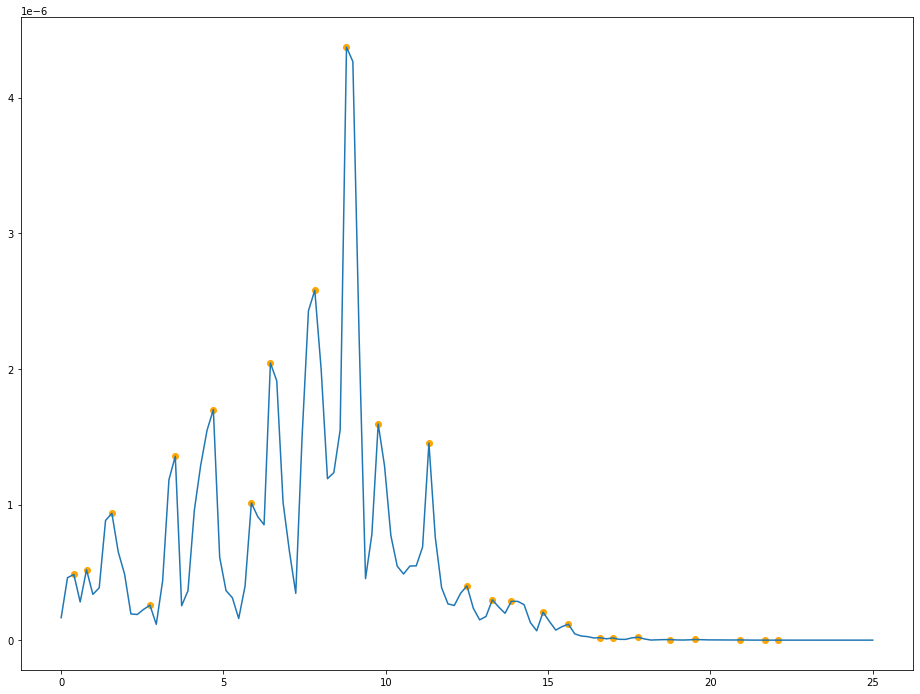

In [228]:
plt.plot(x,fft)
plt.scatter(x = x[peaks],y=_["peak_heights"], c="orange")

## Merge time and frequency domain

In [153]:
features = agg_df.merge(fft_agg_df,on="block")

## ML Prototype

In [154]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [204]:
X_train, X_test, y_train, y_test = train_test_split(features, activity_labels,random_state=42, test_size = 0.3)



pipe = Pipeline([("imputer", SimpleImputer(fill_value = 0)),
                 ('scaler', StandardScaler()), ('svc', SVC(C=400,gamma=0.001, kernel="rbf"))])

In [191]:
X_train.to_csv("../data/X_train.csv")
X_test.to_csv("../data/X_test.csv")
y_train.to_csv("../data/y_train.csv")
y_test.to_csv("../data/y_test.csv")

In [165]:
parameters = [{'svc__kernel': ['rbf'], 'svc__gamma': [1e-2, 1e-3, 3e-4, 1e-5],
                     'svc__C': [1, 10, 100, 200, 400, 600, 1000]},
              {'svc__kernel': ['linear'], 'svc__C': [1, 10, 100, 200, 400, 600, 1000]},]
#               {'svc__kernel': ['poly'], 'svc__degree': [x for x in range(2,7)],
#                      'svc__C': [x for x in range(5,15)]}]

search = GridSearchCV(pipe, param_grid=parameters)

In [205]:
# search.fit(X_train,y_train)
pipe.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(fill_value=0)),
                ('scaler', StandardScaler()),
                ('svc', SVC(C=400, gamma=0.001))])

In [206]:
# accuracy_score(y_test,search.predict(X_test))
accuracy_score(y_test,pipe.predict(X_test))

0.9735997145915091

In [168]:
search.best_params_

{'svc__C': 400, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}

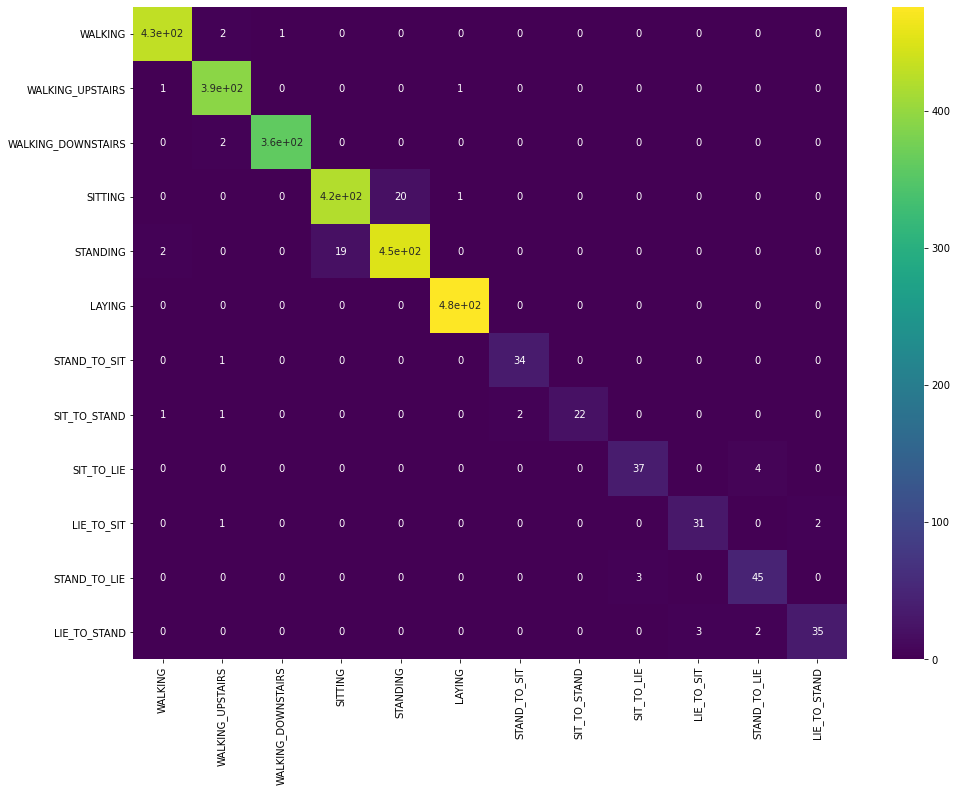

In [160]:
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_test,pipe.predict(X_test)), annot=True, cmap="viridis",
            xticklabels=["WALKING",
                       "WALKING_UPSTAIRS",
                       "WALKING_DOWNSTAIRS",
                       "SITTING",
                       "STANDING",
                       "LAYING",
                       "STAND_TO_SIT",
                       "SIT_TO_STAND",
                       "SIT_TO_LIE",
                       "LIE_TO_SIT",
                       "STAND_TO_LIE",
                       "LIE_TO_STAND"],
            yticklabels=["WALKING",
                       "WALKING_UPSTAIRS",
                       "WALKING_DOWNSTAIRS",
                       "SITTING",
                       "STANDING",
                       "LAYING",
                       "STAND_TO_SIT",
                       "SIT_TO_STAND",
                       "SIT_TO_LIE",
                       "LIE_TO_SIT",
                       "STAND_TO_LIE",
                       "LIE_TO_STAND"])


In [172]:
scores = cross_val_score(pipe, X_train, y_train, cv=5)

In [190]:
print('Accuracy of the model: {}% ±{}%'.format(round(np.mean(scores)*100,2), round(np.std(scores)*100,2)))

Accuracy of the model: 97.22% ±0.39%
